In [2]:
from scipy.stats import linregress
from netCDF4 import Dataset
import cartopy.crs as ccrs
import matplotlib.animation as animation
from IPython import display
import cartopy
import pickle
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import tqdm
import mask
from regrid import regrid
from cartoplot import cartoplot

/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


# get lon/lat coords and mask

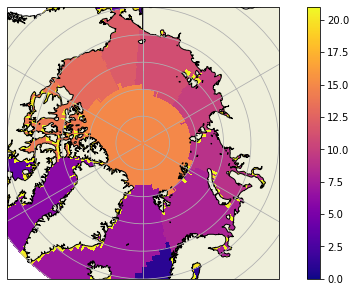

In [12]:
d = Dataset('/media/robbie/TOSHIBA EXT/E5_ros/2020.nc')
lon = d['longitude']
lat = d['latitude']

elons = mask.get('lon')
elats = mask.get('lat')
emask = mask.get('mask')

lon_grid, lat_grid = np.meshgrid(lon,lat)

era_mask = regrid(emask,elons,elats,lon_grid,lat_grid)

cartoplot(lon_grid,lat_grid,era_mask)

cos_lats = np.cos(np.deg2rad(lat_grid))

cos_lats_3d = np.repeat(cos_lats[np.newaxis,:,:],3,axis=0)


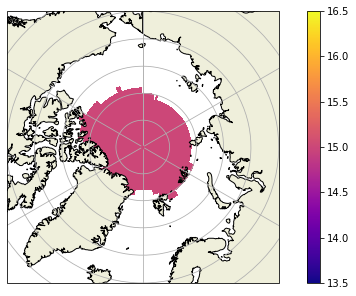

In [4]:
ca_mask = era_mask.copy()
ca_mask[ca_mask != 15] = np.nan
cartoplot(lon_grid,lat_grid,ca_mask)

## What's going on?

First thing that happens is that all frozen precipitation is set to zero.

Then everwhere outside the Central Arctic is set to nan.

So the subregion is +ve vals where it's wet, and 0 where it's not.

The mean wet precipitation per hour is then taken. 

We then do this again, but precip less than 5 mm per day is set to zero.

So the mean strong wet precipitation per hour is then taken. But it's the mean over the whole area where zeros are common.

In [17]:
year = 1981

oct1_doy = datetime.datetime(year,10,1).timetuple().tm_yday
may1_doy = datetime.datetime(year,5,1).timetuple().tm_yday

dec1_doy = datetime.datetime(year,12,1).timetuple().tm_yday
feb1_doy = datetime.datetime(year,3,1).timetuple().tm_yday   

start_year = 1980
end_year = 2020

for (start_doy, end_doy), name in zip([(oct1_doy,may1_doy),
                                       (dec1_doy,feb1_doy)],
                                      ['oct-may',
                                       'dec-feb']):

    mean_data_list = []
    threshold_data_list = []

    for year in tqdm.trange(start_year,end_year+1):

        d = Dataset(f'/media/robbie/TOSHIBA EXT/E5_ros/{year}.nc')

        type_data_raw = d['ptype']
        prec_data_raw = d['tp']

 

        may_type_data = type_data_raw[:(end_doy-1)*24]
        may_prec_data = prec_data_raw[:(end_doy-1)*24]

        oct_type_data = type_data_raw[(start_doy-1)*24:]
        oct_prec_data = prec_data_raw[(start_doy-1)*24:]

        type_data = np.concatenate((may_type_data,oct_type_data))
        prec_data = np.concatenate((may_prec_data,oct_prec_data))*1000

        prec_data[np.isin(type_data,[5,8])] = 0

        ############

        # No threshold

        prec_data_sum = np.nanmean(prec_data,axis=0)

        prec_data_sum[era_mask != 15] = np.nan    

        mean_data_list.append(prec_data_sum)    

        ############

        # Threshold

        prec_data[prec_data < (5/24)] = 0

        prec_data_sum = np.nanmean(prec_data,axis=0)

        prec_data_sum[era_mask != 15] = np.nan    

        threshold_data_list.append(prec_data_sum)
        
    pickle.dump([mean_data_list, threshold_data_list], open(f'pickles/{name}.p', 'wb'))
    
#     break
    


100%|██████████| 41/41 [01:31<00:00,  2.22s/it]


In [18]:
oct_may = pickle.load( open(f'pickles/oct-may.p', 'rb'))
dec_feb = pickle.load( open(f'pickles/dec-feb.p', 'rb'))

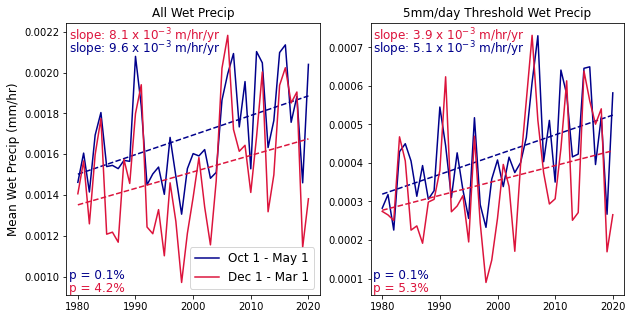

In [40]:
# masked_data = np.ma.masked_array(mean_data, np.isnan(mean_data))

regs = {}

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

for j, color, label in zip(
                           [oct_may, dec_feb],
                           ['darkblue','crimson'], 
                           ['Oct 1 - May 1',
                            'Dec 1 - Mar 1',]
                          ):

    for i, ax, t in zip(j,(ax1,ax2),['no_thres','thres']):

        cos_lats_3d = np.repeat(cos_lats[np.newaxis,:,:],len(i),axis=0)

        weighted = np.multiply(cos_lats_3d, i)

        timeseries = np.nanmean(weighted,axis=(1,2))

        ax.plot(np.arange(start_year,end_year+1),timeseries,label=label,color=color)
        
        regression = linregress(np.arange(start_year,end_year+1),timeseries)
        
        ax.plot([start_year,end_year],
                [start_year*regression[0]+regression[1],end_year*regression[0]+regression[1]],
                ls='--',
                color=color)
        
        yanno = 0.06 if label == 'Oct 1 - May 1' else 0.01
        slope_units = r'x 10$^{-3}$ m/hr/yr'
        
        ax.annotate(text=f'p = {np.round(regression[3]*100,decimals=1)}%',xy=(0.01,yanno),
                    xycoords='axes fraction',fontsize='large',color=color)
        
        ax.annotate(text=f'slope: {np.round(regression[0]*1000_000,decimals=1)} {slope_units}',xy=(0.01,1-yanno),
            xycoords='axes fraction',fontsize='large',color=color,ha='left',va='top')
        
        regs[label+t] = regression
        

ax1.set_ylabel('Mean Wet Precip (mm/hr)',fontsize='large')
ax1.set_title('All Wet Precip',fontsize='large')
ax2.set_title('5mm/day Threshold Wet Precip',fontsize='large')
ax1.legend(fontsize='large',loc='lower right')

    # type_data = np.array(type_data_list)

    # print(type_data.shape)
    
plt.savefig('ROS_trends.jpg',dpi=500,bbox_inches='tight')